# Unresolved resonance region: probability tables

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [1]:
name=''

We have seen before, that above few eV the nuclear cross sections show resonant behaviour. We can recall that this is a consequence of compound nucleus formation which has a high probability if the combined energy of the neutron and the target nucleus aligns with an energy level of the compound nucleus. We have also reviewed how these resonances are stored in the ENDF files: the energy where the resonance occurs and the width of the resonance is given, which can be used to reconstruct point-wise representations of the cross section. However by looking at the point-wise representation, it is apparent that at a certain energy the cross section seems to become flat. Resonances do appear at these energies as well, however we are unable to resolve them experimentally, hence this region is called Unresolved resonance region, or URR. This region is shaded gray for U-238 below. Nevertheless, resonances in this region still contribute to self-shielding and are important for Doppler-broadaning: it is important to take them into account, espescially for fast systems.

If you would like to review other regions of the cross sections, you can refresh your knowledge by browsing through the introduction of [J. Walsh's PhD thesis](https://dspace.mit.edu/handle/1721.1/106700)

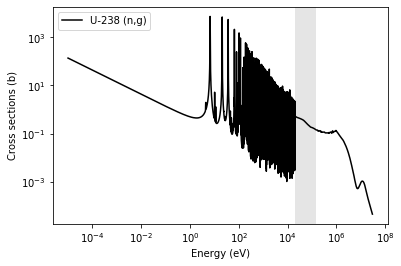

In [2]:
import numpy as np
import matplotlib.pyplot as plt

exs,xs=np.loadtxt('data/U238pw.dat',skiprows=2).transpose()
plt.figure()
plt.loglog(exs,xs, 'k', label='U-238 (n,g)')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross sections (b)')
plt.axvspan(2.0e4, 1.490288e5, color='gray', alpha=0.2, lw=0)
plt.legend()
plt.show()

The treatment of URR is still a heavily studied field of reactor physics. The most widely applied method is to use probability tables to describe the cross sections in this region. In this notebook we do not try to implement a comprehensive, state-of-the-art treatment of the URR, the goal is rather to review the key ideas of the probability tables method, and to introduce the "lingo" of the field.

## Probability tables

For a function $f(x)$ with $x_1\leq x\leq x_2$ the probability density $\Pi(f)$ is defined so that $\Pi(f)df$ equals the probability for function $f(x)$ to have a value within $[f,f+df]$ inside the domain $x_1\leq x\leq x_2$. The probability density is normalized so that $\int_{min(f)}^{max(f)}\Pi(f)df=1$.

As an example we are going to borrow from [Alain Hébert's Applied Reactor Physics](https://www.amazon.com/Applied-Reactor-Physics/dp/2553014368), and work with the function

$$f(x)=(x+1)sin(x)$$

in the domain $1\leq x \leq 9.5$, because this seemingly innocent function will result in a rather interesting probability density function.

Let's first plot this function in the given interval.

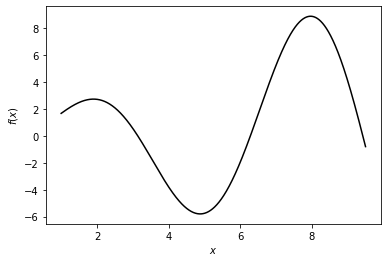

In [3]:
def f(x):
    return (x+1)*np.sin(x)

x=np.linspace(1,9.5,1000000)
#x=np.logspace(np.log10(1),np.log10(9.5),1000000)

plt.figure()
plt.plot(x,f(x),'k')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.show()

So what is the simplest way of evaluating the probability density? Well, we can just call `np.histogram()` on `f(x)`, and that will do the trick for us. Only thing we will need to do is to renormalize the histogram in order to have a probability density function. It is not the most elegant thing to do (why? try `x=np.logspace(np.log10(1),np.log10(9.5),1000000)`, and you will see that the probability density is fairly sensitive to the way of sampling; also clearly the histogram gives a discrete distribution), but it gets the job done. Notice, that earlier we have evaluated `f(x)` at 1million points to make sure that the histogram is going to be smooth. 

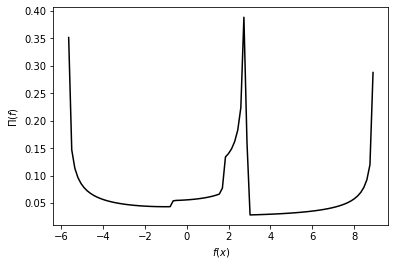

In [4]:
freqbins=np.histogram(f(x),100)
plt.figure()
plt.plot(freqbins[1][1:],freqbins[0]/sum(freqbins[0])/np.diff(freqbins[1]),'k')
plt.xlabel(r'$f(x)$')
plt.ylabel(r'$\Pi (f)$')
plt.show()

This probability density can be approximated with a discrete probability table:

$$\Pi'(f)=\sum_{i=1}^{N}\omega_i\delta(f-f_i)$$

where $\delta(f-f_i)$ is the Dirac delta distribution. For normalization we require $\sum_i \omega_i=1$. 

The set 

$\omega_i,f_{i} \quad \text{with} \: i=1 \: \text{to} \: N$

is an order N probability table.

It is clear that generating probability tables results in some loss of information: we can use the probability table to sample values  of the $f(x)$ (ie. draw a random number within $[0,1]$ and use the cumulative distribution - as shown below - to obtain a randomly sampled $f(x)$ value) but only for the whole domain. 

If we consider now that our $f(x)$ is function is some cross section $\sigma(E)$, then with probability tables we can replace the cross section with a set of discrete probability-cross section pairs: 

$p_i,\sigma_{t,i} \quad \text{with} \: i=1 \: \text{to} \: N$

and one can further calculate partial cross sections from the total cross section.

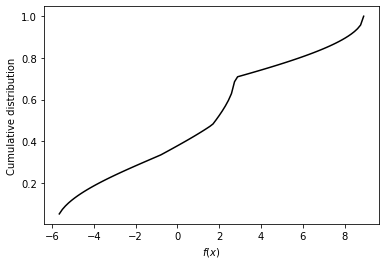

In [5]:
plt.figure()
plt.plot(freqbins[1][1:],np.cumsum(freqbins[0]/sum(freqbins[0])),'k')
plt.xlabel(r'$f(x)$')
plt.ylabel('Cumulative distribution')
plt.show()

As mentioned above, our naive approach to generate the probability table might not be the best approach. The interested reader is referred to [Sublet and Ribon's article on CALENDF](https://doi.org/10.1080/00223131.2002.10875233) to learn more how to obtain the quadrature set. 

## URR

Okay, enough math, let's get back to physics! So, probability tables could be used to represent the resonance region, but they are even more frequently used to tackle the unresolved resonance region.

In the URR, eventhough we do not exactly know where the resonances are located and what their widths are, the ENDF evaluations include the average spacing between resonances and the average resonance partial width. The spacing follows the Wigner-distribution and the widths follow the $\chi^2$-distribution. And these values can be used to sample a pseudo-resonant cross section, which is often referred to as a "ladder". Then these ladders are used to determine the probability tables. By generating several ladders one can improve the accuracy of the probability tables.

The process is described in slide 40 of this [seminar from JAEA](https://rpg.jaea.go.jp/download/frendy/seminar/01.Overview_of_nuclear_data_and_processing_ver1.7.pdf) or in [M. Vorabbi's presentation on fitting probability tables](https://www-nds.iaea.org/index-meeting-crp/TM-NDP-2021/doc/Brown_BNL_CM-ProcessingCodes.pdf), and we will follow the same algorithm:

1. Sample the resonance energy: the center for the first resonance is chosen from a uniform distribution (see p636 of the [NJOY16 manual](https://raw.githubusercontent.com/njoy/NJOY2016-manual/master/njoy16.pdf)), then the spacing is randomly sampled from the Wigner-distribution to get the center of the second, third, etc. resonances: the center of the *i*th resonance is at $E_{r,i}=E_{r,i-1}+\bar{d}r_W$, where $\bar{d}$ is the average spacing, and $r_W$ is a random number according to the Wigner distribution. The Wigner-distribution can be given as (see eg. A. Hébert's Applied Reactor Physics)$$S(x)=\frac{\pi}{2}xe^{-\frac{\pi}{4}x^2} \quad \text{with} \: x=d/\bar{d}$$ In order to make sure that we do this sampling correctly, we can refer to the [source code of the PURR Module of NJOY16](https://github.com/njoy/NJOY2016/blob/master/src/purr.f90), where at line 1721-1732 the Wigner-distribution is sampled (this is rule C50 in the [Monte Carlo Sampler from Los Alamos (LA-9721)](https://mcnp.lanl.gov/pdf_files/la-9721.pdf)).

```fortran
     dcon=dbar(nseqz)*sqrt(4/pi)
     ....
     rr=rann(kk)
     er(ir)=er(ir-1)+dcon*sqrt(-log(rr))
 ```
 
 Let us turn this into a Python function, and in the meantime visualize the distribution.

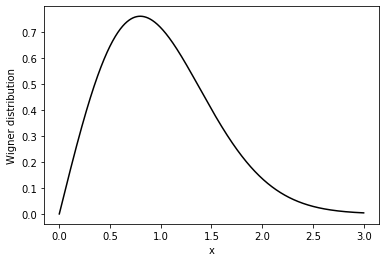

In [6]:
def wigner(d):
    '''
    Sampling Wigner distribution
    
    Parameter
    ---------
    d : float
        Average spacing between energy levels
    '''
    return d*np.sqrt(-4*np.log(np.random.random())/np.pi)

x=np.linspace(0,3,1000)
wignerDistribution =  lambda x : np.pi/2*x*np.exp(-np.pi/4*x**2)
plt.figure()
plt.plot(x,wignerDistribution(x),'k')
plt.xlabel('x')
plt.ylabel('Wigner distribution')
plt.show()

2. Sample the resonance widths. It was shown by Porter and Thomas that the resonance width (and as we will discuss soon, in case of the neutron width, the reduced neutron width) follows a $\chi^2$-distribution. $$P(x,k)=\frac{k}{2G(k/2)}\Big(\frac{k x}{2}\Big)^{\frac{k}{2}-1}e^{-\frac{kx}{2}} \quad \text{with} \: x=\Gamma_r/\bar\Gamma_r$$ where $G()$ is the gamma function (commonly noted with $\Gamma()$, however we do not want to confuse it with our resonance width notation).  Thus we can sample the width as $\Gamma_{r,i}=\bar{\Gamma_r}\frac{r_{\chi^2,k}}{k}$ where $\bar{\Gamma_r}$ is the average resonance width, and $r_{\chi^2,k}$ is a random number sampled from a $\chi^2$-distribution with $k$ degrees of freedom. The number of degrees of freedom equals to the number of decay channels of the compound nucleus (ie. how many different ways it can decay). To perform this sampling, we will use the `np.random.chisquare()` method. Let's visualize the distribution.

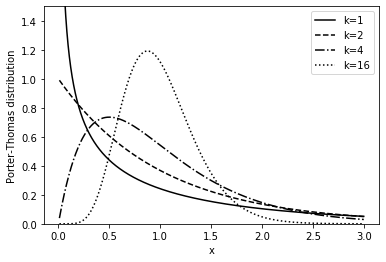

In [7]:
def PorterThomasDistribution(x,k):
    from scipy.special import gamma
    return k/2/gamma(k/2)*(k*x/2)**(k/2-1)*np.exp(-k*x/2)

x=np.linspace(0.01,3,10000)

style={1:'k-',2:'k--',4:'k-.',16:'k:'}
plt.figure()
for k in [1,2,4,16]:
    plt.plot(x,PorterThomasDistribution(x,k),style[k],label='k={}'.format(k))
plt.xlabel('x')
plt.ylabel('Porter-Thomas distribution')
plt.ylim(0.0,1.5)
plt.legend()
plt.show()

We can note that as the number of degrees of freedom increases the distribution converges to a Dirac-delta function. For example, during radiative capture there are many possible decay channels (the compound nucleus can relax down from its excited state to many other energy levels), therefore the radiative width can be considered almost constant.

3. After building the ladder (ie. reconstructing the resonances from the energies and widths), we are going to determine the probability density (strictly speaking the discrete probability table), similarly as before, with our naive approach of using `np.histogram`.
4. Repeat 1-3 to realize more ladders.

We can find the average spacing and resonance width values in the resonance files MF=2 LRU=2. For example using [NDS-IAEA](https://www-nds.iaea.org/), we can access the RES data for U-238, and print it as a table when clicking "Interpreted" for ENDF/B-VII.1. Note, that this is the same way how we accessed earlier the resonances in the resolved range. If we scroll through the resolved resonance parameters, we reach the unresolved resonance parameters for each spin sequence. Here we include only the values for L=0.

```
    Energy range number: 2
    Lower energy limit: 2.000000+4
    Upper energy limit: 1.490288+5

    Unresolved Parameters
    all parameters are energy dependent

    Spin: 0.0
    Scattering length AP: 0.94338
    4*pi*AP**2: 11.1836 barns
    LSSF: 1
    Number of l states: 3

    L = 0 ( 1 J states)

    J = 0.5
    Interpolation law: 5

     Degrees of freedom:
           zero       zero       AMUX       AMUN       AMUG       AMUF
     ---------- ---------- ---------- ---------- ---------- ----------
     0.000000+0 0.000000+0 2.000000+0 1.000000+0 0.000000+0 0.000000+0

     Parameters:
             ES          D         GX        GN0         GG         GF
     ---------- ---------- ---------- ---------- ---------- ----------
     2.000000+4 2.199760+1 0.000000+0 2.063460-3 2.281190-2 0.000000+0
     2.300000+4 2.185120+1 0.000000+0 2.043260-3 2.284390-2 0.000000+0
     2.600000+4 2.170590+1 0.000000+0 2.023690-3 2.287600-2 0.000000+0
     3.000000+4 2.151390+1 0.000000+0 1.998440-3 2.291910-2 0.000000+0
     3.500000+4 2.127610+1 0.000000+0 1.967970-3 2.297280-2 0.000000+0
     4.000000+4 2.104110+1 0.000000+0 1.938570-3 2.302660-2 0.000000+0
     4.500000+4 2.080860+1 0.000000+0 1.910100-3 2.308050-2 0.000000+0
     4.509020+4 2.080440+1 0.000000+0 1.909600-3 2.308140-2 0.000000+0
     5.000000+4 2.057890+1 1.097450-5 1.882470-3 2.313450-2 0.000000+0
     5.500000+4 2.035200+1 6.242520-5 1.855610-3 2.318890-2 0.000000+0
     6.000000+4 2.012740+1 1.703450-4 1.829400-3 2.324300-2 0.000000+0
     7.000000+4 1.968630+1 5.935770-4 1.778900-3 2.335250-2 0.000000+0
     8.000000+4 1.925540+1 1.332900-3 1.730620-3 2.346240-2 0.000000+0
     9.000000+4 1.883420+1 2.416260-3 1.684330-3 2.357300-2 0.000000+0
     1.000000+5 1.842260+1 3.857070-3 1.639840-3 2.368410-2 0.000000+0
     1.200000+5 1.762720+1 7.818620-3 1.555690-3 2.390780-2 0.000000+0
     1.400000+5 1.686740+1 1.317280-2 1.477270-3 2.424070-2 0.000000+0
     1.490288+5 1.653580+1 1.601860-2 1.443570-3 2.434410-2 0.000000+0
```

One can immedietly notice that the neutron width is not given as "GN", but as "GN0". The reason being that the neutron width is dependent on the incident energy and it is the $\Gamma_n^\ell/\bar\Gamma_n^\ell$ value which obeys the Porter-Thomas distribution, where $\Gamma_n^\ell$ is the reduced neutron width and $\bar\Gamma_n^\ell$ is the average reduced neutron width (GN0). In order to obtain the neutron width we will have to take into account the penetrability of the potential barrier:

$$\Gamma_n=\Gamma_n^\ell\sqrt{E}v_\ell(E)$$

One can find further details in the [ENDF manual](https://www.oecd-nea.org/dbdata/data/manual-endf/endf102.pdf) (see D2.2.2 in p342). Therefore sampling the neutron width requires some special attention by evaluating the neutron wave number and channel radius etc. However, in this notebook we will be a bit ignorant, and focus only on the $\ell=0$ case, when $v_\ell(E)=0$.
 
Let's pythonize the table above, and visualize some of the parameters.

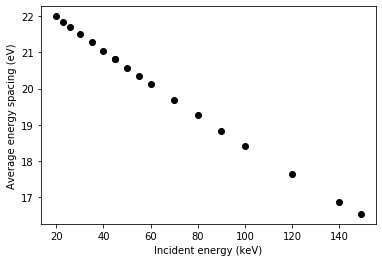

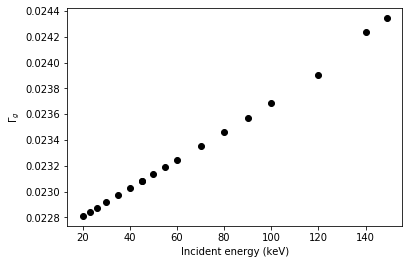

In [8]:
urrparameters = np.array([[2.000000e+4,2.199760e+1,0.000000e+0,2.063460e-3,2.281190e-2,0.000000e+0],
                          [2.300000e+4,2.185120e+1,0.000000e+0,2.043260e-3,2.284390e-2,0.000000e+0],
                          [2.600000e+4,2.170590e+1,0.000000e+0,2.023690e-3,2.287600e-2,0.000000e+0],
                          [3.000000e+4,2.151390e+1,0.000000e+0,1.998440e-3,2.291910e-2,0.000000e+0],
                          [3.500000e+4,2.127610e+1,0.000000e+0,1.967970e-3,2.297280e-2,0.000000e+0],
                          [4.000000e+4,2.104110e+1,0.000000e+0,1.938570e-3,2.302660e-2,0.000000e+0],
                          [4.500000e+4,2.080860e+1,0.000000e+0,1.910100e-3,2.308050e-2,0.000000e+0],
                          [4.509020e+4,2.080440e+1,0.000000e+0,1.909600e-3,2.308140e-2,0.000000e+0],
                          [5.000000e+4,2.057890e+1,1.097450e-5,1.882470e-3,2.313450e-2,0.000000e+0],
                          [5.500000e+4,2.035200e+1,6.242520e-5,1.855610e-3,2.318890e-2,0.000000e+0],
                          [6.000000e+4,2.012740e+1,1.703450e-4,1.829400e-3,2.324300e-2,0.000000e+0],
                          [7.000000e+4,1.968630e+1,5.935770e-4,1.778900e-3,2.335250e-2,0.000000e+0],
                          [8.000000e+4,1.925540e+1,1.332900e-3,1.730620e-3,2.346240e-2,0.000000e+0],
                          [9.000000e+4,1.883420e+1,2.416260e-3,1.684330e-3,2.357300e-2,0.000000e+0],
                          [1.000000e+5,1.842260e+1,3.857070e-3,1.639840e-3,2.368410e-2,0.000000e+0],
                          [1.200000e+5,1.762720e+1,7.818620e-3,1.555690e-3,2.390780e-2,0.000000e+0],
                          [1.400000e+5,1.686740e+1,1.317280e-2,1.477270e-3,2.424070e-2,0.000000e+0],
                          [1.490288e+5,1.653580e+1,1.601860e-2,1.443570e-3,2.434410e-2,0.000000e+0]])

plt.figure()
plt.plot(urrparameters[:,0]/1000,urrparameters[:,1],'ko')
plt.xlabel('Incident energy (keV)')
plt.ylabel('Average energy spacing (eV)')
plt.show()

plt.figure()
plt.plot(urrparameters[:,0]/1000,urrparameters[:,4],'ko')
plt.xlabel('Incident energy (keV)')
plt.ylabel(r'$\Gamma_g$')
plt.show()

We can notice that both the average spacing and the average width depends approximately lineary on the incident energy. Besides the physical implications of this dependence (eg. resonances are more densely packed at higher energies), one can also conclude, that in the above mentioned algorithm to generate a resonance ladder, one could apply linear interpolation to update the average spacing and width at each energy. In the following however, we will neglect this, and only use the average spacing in the table.

The values AMUX, AMUN, AMUG, AMUF are the number of degrees of freedom in the width distributions (see p70 in the [ENDF-6 format manual](https://www.oecd-nea.org/dbdata/data/manual-endf/endf102.pdf)), and since AMUG is always 0.0, this implies a constant value of $\Gamma_\gamma$. (See discussion above on the number of possible decay channels for radiative capture.)


### Building a ladder

The above given algorithm to generate a realization of a resonance ladder should be done for each spin sequence. Here we will disregard that, and only generate a ladder for L=0, and only for energies within 20 keV and 23 keV (hence the expected number of resonances in our ladder is going to be $3000 \: \text{eV}/22 \: \text{eV}\approx136)$. We will care only about the radiative width and the neutron width. Also, as said before, we will consider that the average spacing and resonance width is constant within this energy interval. Our result will not be physically correct, but it will be good enough to demonstrate the underlying idea. Also, typically the probability tables are generated for the total cross sections, and the probabilities for the partial cross sections are deduced from that. For simplicity, we will only work now with the capture cross section. Also, we are considering that the temperature is 0K, and do not broaden the resonances. In realistic applications the probability tables are typically given at several temperatures, which involves an extra step to perform Doppler broadening.

We will reconstruct the resonances with the Single-level Breit-Wigner formalism as earlier. Let's define a function implementing the code we developed earlier.

In [9]:
def SLBW(E0s,Js,GNs,GGs,I=0.0,A=238,Emin=20000,Emax=23000,N=10000):
    """Reconstruct resonances with SLWB formalism
    
    Parameters
    ----------
    
    E0s : list
        List of resonance energies
    Js : list
        List of J spins
    GNs: list
        List of neutron widths
    GGs: list
        List of gamma widths
    I : float
        Nuclear spin (default=0.0)
    A : int
        Mass number of target (default=238)
    Emin : float
        Minimum energy for the reconstruction
    Emax : float
        Maximum energy for the reconstruction
    N : int
        Number of energy points for the reconstruction.
        
    Returns
    -------
    E : np.array
        Energy values where the point-wise cross section is given
    sigma_g : array
        Point-wise cross section values after reconstruction
    """
    E=np.logspace(np.log10(Emin), np.log10(Emax), N) 
                                                      
    sigma_g = np.zeros_like(E)

    for E0,J,GN,GG in zip(E0s,Js,GNs,GGs):
        G=GN+GG                  #total line width
        g = (2*J+1)/(2*(2*I+1))  #statistical spin factor

        sigma_0 = 2.608e6 * (A+1)**2/(A**2 * E0) * (GN/G) * g

        y = (2/G)*(E - E0)
        sigma_g += sigma_0 * (GG/G) * np.sqrt(E0/E) * (1/(1+y**2))
    return (E,sigma_g)

So let's finally build that ladder!

In [10]:
def ladder(d=2.199760e+1,aGN=2.063460e-3,aGG=2.281190e-2,
                AMUN=1.0,AMUG=0.0, J=0.5, A=238, Emin=20000.,Emax=23000.,
          plot=False):
    """
    Function to build a resonance ladder
    
    Parameters
    ----------
    d : float
        Average spacing between resonances
    aGN : float
        Average reduced neutron width
    aGG : floa
        Average radiation width
    AMUN : float
        Number of degrees of freedom in neutron width distribution
    AMUG : float
        Average spacing between resonances
    
    Note
    ----
    
    Other parameters are same as in SLBW() function. Default values are representative to the unresolved
    resonances of U-238 in the 20-23 keV energy interval.
    """
    
    E0s=[]
    Js=[]
    GNs=[]
    GGs=[]
    
    #building the ladder
    E0=Emin
    while E0<Emax:
        if len(E0s)==0:
            E0 = Emin + np.random.random()*d #Based on NJOY manual for Purr
        else:
            E0 = E0s[-1]+wigner(d)
        E0s.append(E0)
        if AMUN == 0.0:    #danger zone: float comparison
            gn = aGN
        else:
            gnl = np.random.chisquare(AMUN) #sampling $x=\Gamma_n^\ell/\bar\Gamma_n^ell
            gn = np.sqrt(E0)*gnl*aGN #neutron width from the reduced width statistics
        GNs.append(gn)
        gg=aGG           #AMUG=0.0 always, hence no need for conditional. this is constant.
        GGs.append(gg)
        Js.append(J)
    
    #reconstruct the cross section
    E,sigg=SLBW(E0s,Js,GNs,GGs,0.0,238.)
    
    #If required, plot the ladder
    if plot:
        print('Number of resonances in the ladder: {}'.format(len(E0s)))
        plt.figure(figsize=(14,4))
        for e0 in E0s:
            plt.axvline(e0,color='k')
        plt.xlim(Emin,Emax)
        ax = plt.gca()
        ax.axes.yaxis.set_ticklabels([])
        plt.xlabel('Resonance energy (eV)')
        plt.show()
        
        plt.figure(figsize=(14,4))
        plt.semilogy(E,sigg,'k')
        plt.xlim(Emin,Emax)
        plt.xlabel('Incident energy (eV)')
        plt.ylabel('Cross section')
        plt.show()
    return (E,sigg)

Let's visualize one realization of such a ladder. The `ladder()` function has a parameter `plot` which will invoke plotting the ladder. We can also verify to some level that the code is working as expected by noticing that the number of resonances in the ladder fluctuates around the number we have expected.

Number of resonances in the ladder: 131


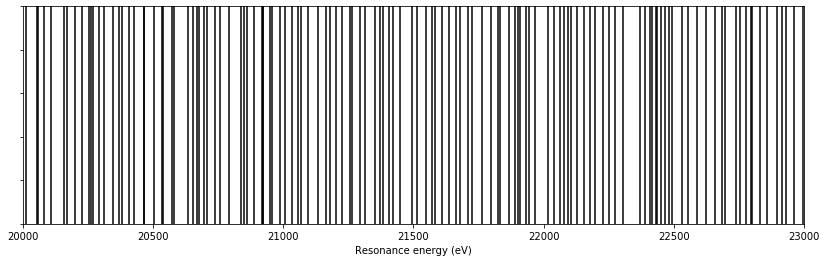

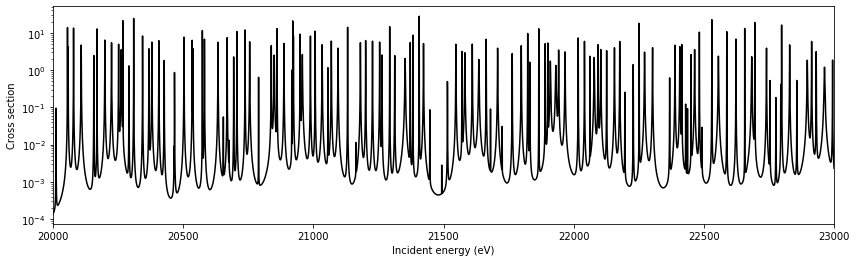

In [11]:
E,sigg=ladder(plot=True)

If we try to create the probability density based on one ladder, it is going to be rather noisy.

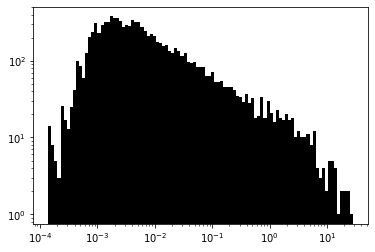

In [12]:
plt.figure()
plt.hist(sigg,bins=np.logspace(np.log10(min(sigg)),np.log10(max(sigg)), 100),log=True,facecolor='k')
plt.xscale('log')
plt.show()

Therefore we are going to sample several realizations of the ladder, and average out the histograms.

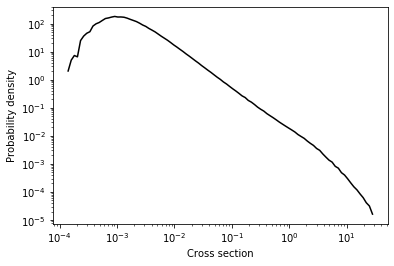

In [13]:
siggs=[]
for _ in range(100):
    E,sigg=ladder()
    siggs.append(sigg)

fs=np.zeros(99) #frequency of occurances
for sigg in siggs:
    #note that we force the the same bin boundaries by evaluating the minimum and maximum of all the realizations
    histo=np.histogram(sigg,bins=np.logspace(np.log10(np.min(siggs)),np.log10(np.max(siggs)), 100))
    f=histo[0]
    fs=fs+f
plt.figure()
plt.loglog(histo[1][:-1],fs/np.sum(fs)/np.diff(histo[1]),'k')
plt.xlabel('Cross section')
plt.ylabel('Probability density')
plt.show()

## Outlook

This concludes our endavaour with tackling the unresolved resonance region. As practice, you can try to improve the methodology by taking into account other spin sequences. Remember, this will require special attention on the neutron width.

The proper treatment of the URR is especially important in fast systems. In thermal systems, assuming average values can still lead to accurate results. The currently most widely accepted method to treat the URR is with probability tables. In practice, as with other steps of the nuclear data processing pipeline, the URR is treated with nuclear data processing codes, such as NJOY, FRENDY or FUDGE. The proper implementation of the above described (and at some places oversimplified) method can be found eg. in the PURR module of NJOY. Such tools can be used to treat self-shielding in the URR as well. As we will see later, when creating eg. continous-cross section data for Monte Carlo codes in the ACE format, PURR is part of the data processing pipeline. 

You can find a well explained notebook at the [openMC documentation site](https://docs.openmc.org/en/v0.9.0/examples/nuclear-data.html) which demonstate how the probability tables in the ACE files can be visualized.

## Acknowledgement

The datalab was inspired by the scripts available at [Amanda L. Lund's github page](https://github.com/amandalund/urr), which implement some aspects of the URR treatment more accurately. Some of these aspects were simplified in this notebook for pedagogical reasons. One main aspect is the proper tackling of the neutron width for various spin sequences. 